# Data Processing - Calculate Wealth Level, Urbanisation Rate, Competition for grids

In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, LineString, Polygon, shape
import math
import seaborn as sns
import requests
import json

----

# Geocompetiton Calculation

In [10]:
## read store data
df_stores = pd.read_csv('./data/lagos_stores.csv')

In [11]:
## Use significant columns
df_stores = df_stores[['Store ID', 'Country', 'City', 'Latitude','Longitude', 'Brand Owner','Brand Owner Origin','Address', 'Company Name', 'Fascia', 'Floorspace', 'Format', 'Price Range']]

In [12]:
## Filter for the format we observe
df_stores = df_stores[df_stores.Format.isin(['Supermarket (Supermarkets, Hypermarkets and Department Stores)','Convenience and Forecourt', 'Traditional'])]

In [13]:
## drop stores without coords if there is any
df_stores.dropna(subset=['Longitude'], inplace=True)

In [14]:
## convert to geopandas DF
gdf_stores = gpd.GeoDataFrame(df_stores, geometry=gpd.points_from_xy(df_stores.Longitude, df_stores.Latitude), crs='EPSG:4326')

### Floorspace - drive distance mapping

| Floospace (m) | Time/Isochrone (mins) |
|:---:|:---:|
| 0 < F <= 50 | 2' |
| 50 < F <= 200 | 5' |
| 200 < F <= 500 | 8' |
| 500 < F <= 1500 | 10' |
| 1500 < F <= 2500 | 15' |
| 2500 < F <= 5000 | 22' |
| 5000 < F | 30' |

In [15]:
## Drive Distance mapping as table below
drive_map= {
    0 : 2,
    50 : 5,
    200 : 8,
    500 : 10,
    1500 : 15,
    2500 : 22,
    5000 : 30,
    1000000 : 1000
}

In [16]:
list(drive_map.keys())

[0, 50, 200, 500, 1500, 2500, 5000, 1000000]

In [17]:
## Assign the mapping to each store based on ther floospace
gdf_stores['Reach'] = pd.cut(gdf_stores['Floorspace'], bins=list(drive_map.keys()),labels=list(drive_map.values())[:-1], include_lowest=True )

In [18]:
gdf_stores['Reach'] = gdf_stores['Reach'].astype(int)

In [19]:
## Calculate no branches in Lagos
gdf_stores = pd.merge(gdf_stores, gdf_stores.groupby('Brand Owner').agg({'Store ID' : 'count'}).rename(columns={'Store ID':'No Branches'}), on='Brand Owner', how='left')

### Calling the Mapbox Isochrome API of each store

In [20]:
## Replace it with your own API key by Mapbox
mapbox_token = 'YOUR_API_KEY'

In [22]:
def get_isochrome(mins, lng, lat, token):
    api_call = f'https://api.mapbox.com/isochrone/v1/mapbox/driving/{lng}%2C{lat}?contours_minutes={mins}&polygons=true&denoise=1&generalize=5&access_token={token}'    
    res = requests.get(api_call)
    isochrome = res.json()
    
    return isochrome

### Calculate isochrone for all stores: Runing for a while

In [25]:
### Calculate isochrone for all stores: Runing for a while
gdf_stores['Catchment Areas'] = gdf_stores.apply(lambda x : get_isochrome( x['Reach'], x['Longitude'], x['Latitude'], mapbox_token ),axis=1)

In [26]:
## Get the shape from the responses - if giving error run to cell above again  - Mapbox sometimes giving errors
gdf_stores['Catchment Areas'] = gdf_stores['Catchment Areas'].apply(lambda x  : shape(x['features'][0]['geometry']) )

In [27]:
## read each catchments in a separate file 
gdf_catchment = gpd.GeoDataFrame(gdf_stores[['Store ID','Brand Owner', 'Floorspace']],geometry=gdf_stores['Catchment Areas'], crs='EPSG:4326')


In [28]:
## Each catchment has the same competition level weight
gdf_catchment['competition_level'] = 1

In [29]:
## Save each catchment areas in a shapefile
gdf_catchment.to_file("./final_data/store_catchment.geojson", driver='GeoJSON')

<AxesSubplot:>

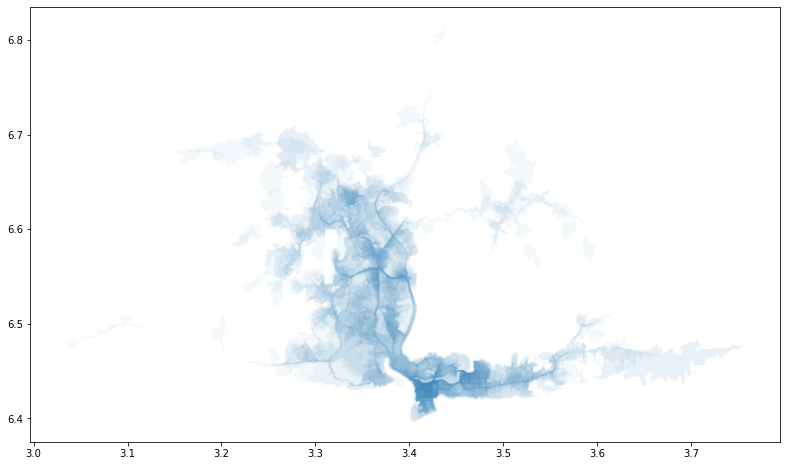

In [30]:
gdf_catchment.plot(alpha=0.05, figsize=(20,8))

## Assign competiton level to each grid
Read Population Grid (already created) in 1Data Processing script

In [31]:
lagos_pop_grid = gpd.read_file("./data/lagos_grid_pop.geojson", driver='GeoJSON')

In [32]:
gdf_catchment = gpd.read_file("./final_data/store_catchment.geojson", driver='GeoJSON')

In [33]:
### inner not good
len(lagos_pop_grid)

5634

In [34]:
grid_catchment = gpd.sjoin(lagos_pop_grid, gdf_catchment, op="intersects", how="left")

##### Add the number of grid the store reaches

In [35]:
### Add the number of grid the store reaches data to the store fle
gdf_stores = pd.merge(gdf_stores, grid_catchment.groupby('Store ID').agg({'grid_id' : 'nunique', 'nga_general_2020' : 'sum'}), on="Store ID", how="left")

In [36]:
## Save to use it in the tool
gdf_stores.drop(columns=['Catchment Areas']).to_file('./final_data/lagos_stores.geojson', driver="GeoJSON")

In [37]:
grid_catchment=grid_catchment.groupby('grid_id').agg({'competition_level' : 'sum', 'Floorspace' : ['sum', 'mean'], 'Store ID' : [list, 'count'], 'Brand Owner' : 'nunique' })

In [38]:
## Flatten columns 
grid_catchment.columns = ['_'.join(col).strip() for col in grid_catchment.columns.values]

In [39]:
## Rename cols
grid_catchment.rename(columns={'competition_level_sum' : 'competition_level', 'Store ID_list' : 'store_id', 'Store ID_count' : 'no_stores', 'Brand Owner_nunique' : 'no_chains'}, inplace = True)

In [40]:
lagos_pop_grid = pd.merge(lagos_pop_grid,  grid_catchment, how="left", on="grid_id")

In [41]:
#lagos_pop_grid['Store ID'] = lagos_pop_grid['Store ID'].astype(str)

In [42]:
lagos_pop_grid['store_id'] = lagos_pop_grid['store_id'].apply(lambda x : '' if pd.isna(x[0])  else ", ".join(x))

# Night-time Light Data - Relative Wealth Lvl
Data from VIIRS DNB


In [43]:
from rasterstats import zonal_stats

In [44]:
light_grids = zonal_stats(lagos_pop_grid, "./data/Lagos_nightlight_20210619.tif")

/opt/conda/envs/sds2020/lib/python3.7/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


#### Add light data mean to the grids GEOJSON

In [45]:
lagos_pop_grid['light_mean']= [i['mean'] for i in light_grids]
lagos_pop_grid['light_min']= [i['min'] for i in light_grids]
lagos_pop_grid['light_max']= [i['max'] for i in light_grids]

<AxesSubplot:>

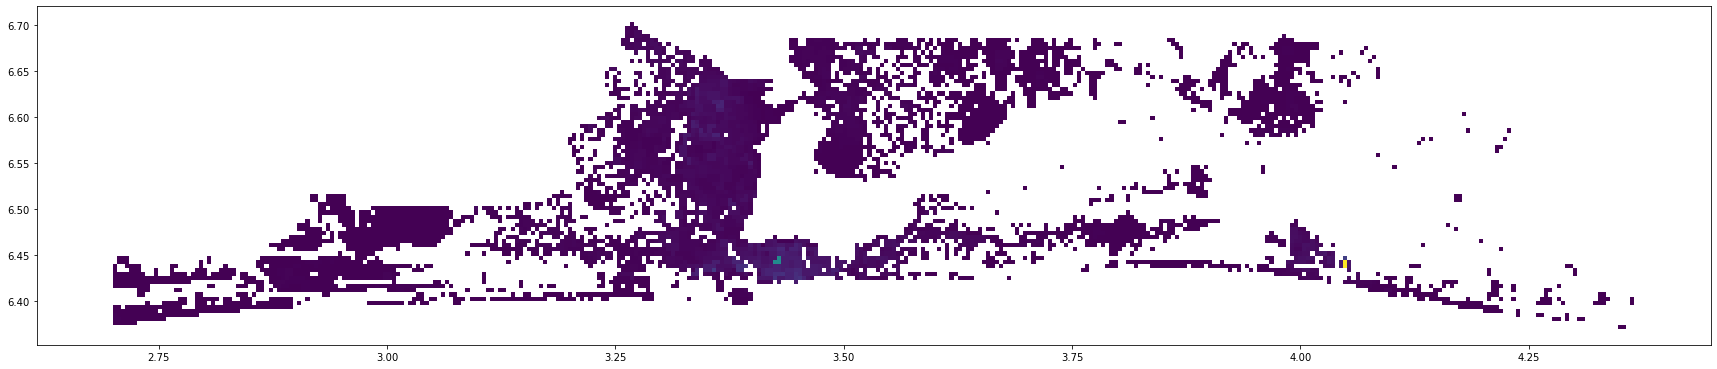

In [46]:
lagos_pop_grid.plot(column='light_mean', figsize=(30,20))

# Land Cover - Urbanisation
data from Copernicus Global

info: https://land.copernicus.eu/global/sites/cgls.vito.be/files/products/CGLOPS1_PUM_LC100m-V3_I3.4.pdf

In [47]:
#https://land.copernicus.eu/global/sites/cgls.vito.be/files/products/CGLOPS1_PUM_LC100m-V3_I3.4.pdf
#cmap = {50 : 'built-up', 112 :'forest', 126 : 'forest', 80 :' water', 200 : 'water'}

In [48]:
land_grids = zonal_stats(lagos_pop_grid, "./data/Lagos_landcover.tif", categorical=True)

In [49]:
# 50 - code for uban

In [50]:
## Calculate urbanisation rate
urban_level = [ 0 if i.get(50) is None else (i.get(50) /  sum(i.values())) for i in land_grids]

In [51]:
lagos_pop_grid['urban_level'] = urban_level
lagos_pop_grid['land_cover'] = land_grids

### Save File
still not final lagos_gird - 3Data Processing is for Finalise data outputs

In [53]:
lagos_pop_grid.to_file("./data/lagos_grid.geojson", driver='GeoJSON')

---

## Creating Lagos Grid Net - Not in Use

In [ ]:
#http://rcn.montana.edu/Resources/Converter.aspx

#https://tool-online.com/en/coordinate-converter.php

# start: 710000; 345000
# 6.37803852; 3.09767755

In [ ]:
startcoord = (6.4, 3.06)
x = 80000 # 80km
y = 40000 # 40km
grid_size = 500

In [ ]:
x/grid_size

In [ ]:
y_coords = [ i * grid_size for i in range(round(y/grid_size))]

In [ ]:
x_coords = [ i * grid_size for i in range(round(x/grid_size))]

In [ ]:
left = []
for y in y_coords:
    for x in x_coords:
        left.append([x,y])

In [ ]:
grids = np.array(left)

In [ ]:
df = pd.DataFrame(grids, columns=['left','bottom'])

In [ ]:
df['top'] = df['bottom'] + grid_size
df['right'] = df['left'] + grid_size


In [ ]:
df[['right','left']] = df[['right','left']] + 345000
df[['top','bottom']]  = df[['top','bottom']] + 710000

In [ ]:
polys = []
for i in df.values:
    polys.append(Polygon([[i[0], i[1]], [i[3], i[1]], [i[3], i[2]], [i[0], i[2]]]) )

In [ ]:
# WGS84 Web Mercator (in meters)
gdf  = gpd.GeoDataFrame(geometry=polys, crs="EPSG:3857")

In [ ]:
# WGS84
gdf = gdf.to_crs('EPSG:4326')

In [ ]:
gdf.crs

In [ ]:
gdf['value'] = np.random.rand(1,len(gdf))[0]

In [ ]:
gdf.to_file("lagos_grid_cover.geojson", driver='GeoJSON')

In [ ]:
## Distance Calc
#https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula?rq=1
    
function distance(lat1, lon1, lat2, lon2) {
  var p = 0.017453292519943295;    // Math.PI / 180
  var c = Math.cos;
  var a = 0.5 - c((lat2 - lat1) * p)/2 + 
          c(lat1 * p) * c(lat2 * p) * 
          (1 - c((lon2 - lon1) * p))/2;

  return 12742 * Math.asin(Math.sqrt(a)); // 2 * R; R = 6371 km
}

In [ ]:
len(gdf) * 400

---

# Huff - Gravity Modell - not in Use

### Create Distance Matrix

In [ ]:
# from scipy.spatial import distance_matrix
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

In [ ]:
## read store data
df_stores = pd.read_csv('lagos_stores.csv')

In [ ]:
gdf_stores = gpd.GeoDataFrame(df_stores, geometry=gpd.points_from_xy(df_stores.Longitude, df_stores.Latitude), crs='EPSG:4326')

In [ ]:
#filter for the intrested formats
gdf_stores = gdf_stores[gdf_stores['Format'].isin(['Supermarket (Supermarkets, Hypermarkets and Department Stores)','Convenience and Forecourt'])]
gdf_stores = gdf_stores[gdf_stores['Status']=='Open']

In [ ]:
len(gdf_stores)

#### Calculate Distances between the centre of grids and the store (few mins to run)

In [ ]:
df = pd.DataFrame()
for i in range(len(gdf_stores)):
    df['distance_' + str(i)] = lagos_pop_grid.to_crs('EPSG:3857').geometry.centroid.distance(gdf_stores.to_crs('EPSG:3857').iloc[i].geometry)

In [ ]:
df.head()

#### Incorporate attractiveness (this case - store size)

In [ ]:
#600 * (df['distance_0'] * df['distance_0'])

In [ ]:
## Transform Floorspace column to do the equatioan matrix level (avoiding loops)
df_floorspace = gdf_stores[['Floorspace']].T
df_floorspace = df_floorspace.loc[df_floorspace.index.repeat(len(df))]
df_floorspace.columns = df.columns
df_floorspace.index = df.index

In [ ]:
## Creating Attractiveness dataframe

In [ ]:
df_attractiveness = df_floorspace / (df * df)

In [ ]:
#Total Attractiveness Score of each grid
df_attractiveness['total_attr'] = df_attractiveness.sum(axis=1)

In [ ]:
## Add Attractiveness to the grids

In [ ]:
df_attractiveness.index.name = 'grid_id'  

In [ ]:
## Adding the total attractiveness to the shapes:
lagos_pop_grid =  pd.merge(lagos_pop_grid, df_attractiveness[['total_attr']], how="left", on='grid_id')

In [ ]:
lagos_pop_grid['total_attr'].plot.hist(bins=20)

In [ ]:
## Min - Max Rescale Attractiveness
lagos_pop_grid['total_attr'] = ((lagos_pop_grid['total_attr'] - lagos_pop_grid['total_attr'].min()) / (lagos_pop_grid['total_attr'].max() - lagos_pop_grid['total_attr'].min())) * 100   

In [ ]:
lagos_pop_grid.to_file("lagos_grid_pop.geojson", driver='GeoJSON')

#### Probablilities - each store's market share in the areas

In [ ]:
df_market_share = df_attractiveness.iloc[:,:-1].div( df_attractiveness['total_attr'], axis=0)

In [ ]:
df_market_share.columns = [ 'market_share_' +  str(i) for i in range(len(df_market_share.columns))]

In [ ]:
df_market_share.describe()